In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('seaborn-paper')
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import math

In [2]:
f = open('C://Users//Think//Desktop/data.csv')
df = pd.read_csv(f)
df1 = df['price_close'][1:len(df)]
df1 = df1.reset_index(drop=True)
df['labels'] = df1
df = df[0:len(df)-1]
data = df.values

In [3]:
batch_size = 100
time_step = 20
train_begin = 0
train_end = 3200

In [4]:
batch_index = []
data_train = data[train_begin:train_end]
normalized_train_data=(data_train-np.mean(data_train,axis=0))/np.std(data_train,axis=0)
train_x,train_y=[],[]

In [5]:
for i in range(len(normalized_train_data)-time_step-1):
    if i % batch_size==0:
        batch_index.append(i)
    x=normalized_train_data[i:i+time_step,:5]
    y=normalized_train_data[i:i+time_step,5,np.newaxis]
    train_x.append(x.tolist())
    train_y.append(y.tolist())
batch_index.append((len(normalized_train_data)-time_step))

In [6]:
rnn_unit = 10
input_size = 5
output_size = 1
lr = 0.006
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
        }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
       }

In [7]:
batch_size=100
time_step=20
train_begin=0
X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])

In [8]:
batch_size = tf.shape(X)[0]
time_step=tf.shape(X)[1]
w_in=weights['in']
b_in=biases['in'] 

In [9]:
input=tf.reshape(X,[-1,input_size])
input_rnn=tf.matmul(input,w_in)+b_in

input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])
cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)

init_state=cell.zero_state(batch_size,dtype=tf.float32)

output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)

output=tf.reshape(output_rnn,[-1,rnn_unit])

w_out=weights['out']
b_out=biases['out']
pred=tf.matmul(output,w_out)+b_out

_ = final_states

loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))

train_op=tf.train.AdamOptimizer(lr).minimize(loss)

saver=tf.train.Saver(tf.global_variables(),max_to_keep=15)

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1,101):
        for step in range(len(batch_index)-1):
            _, loss_ = sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]]})
        print(i, loss_)
        if i % 2 == 0:
            print('save model:',saver.save(sess,'C://PythonWorkspace/python-notebook/TensorFlow/model/stock830.model',global_step=i))

In [11]:
time_step = 20
test_begin= 3200
data_test=data[test_begin:]
mean=np.mean(data_test,axis=0)
std=np.std(data_test,axis=0)
normalized_test_data=(data_test-mean)/std
size=(len(normalized_test_data)+time_step-1)//time_step
test_x,test_y=[],[]

In [ ]:
for i in range(size-1):
    x=normalized_test_data[i*time_step:(i+1)*time_step,:5]
    y=normalized_test_data[i*time_step:(i+1)*time_step,5]
    test_x.append(x.tolist())
    test_y.extend(y)
test_x.append((normalized_test_data[(i+1)*time_step:,:5]).tolist())
test_y.extend((normalized_test_data[(i+1)*time_step:,5]).tolist())

INFO:tensorflow:Restoring parameters from C://PythonWorkspace/python-notebook/TensorFlow/model/stock830.model-100


<IPython.core.display.Javascript object>


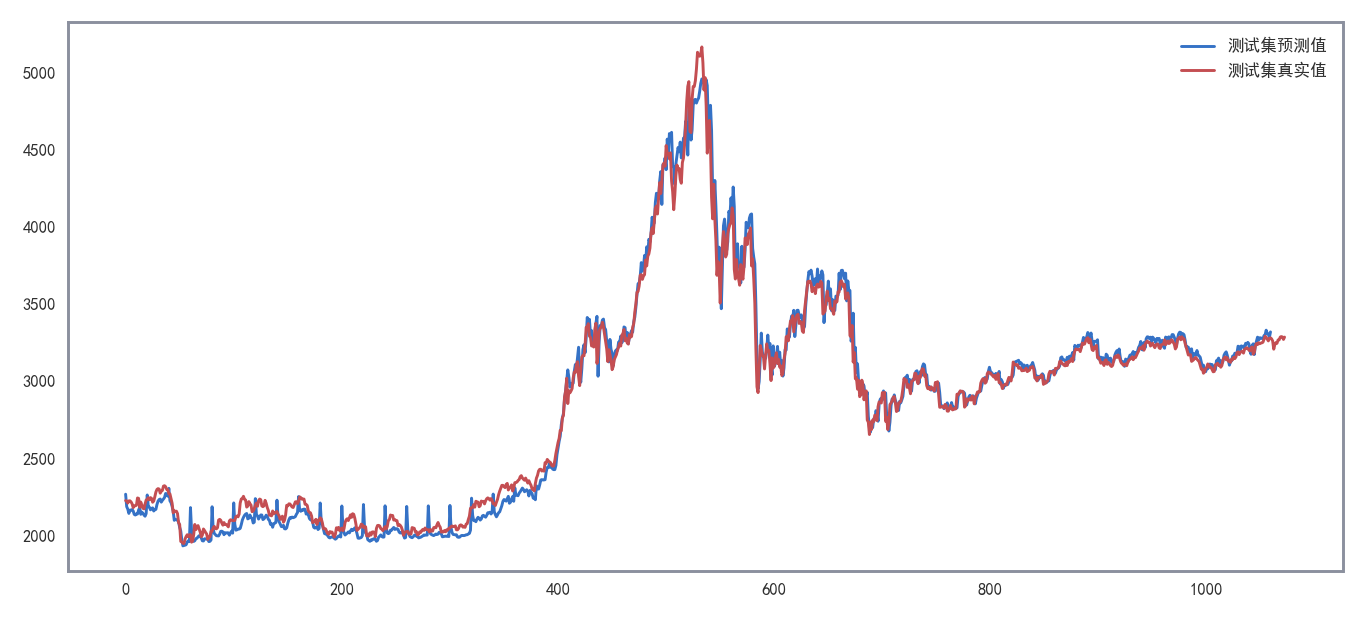

In [13]:
saver=tf.train.Saver(tf.global_variables())
with tf.Session() as sess:
    #参数恢复
    module_file = tf.train.latest_checkpoint('C://PythonWorkspace/python-notebook/TensorFlow/model/')
    saver.restore(sess, module_file) 
    test_predict=[]
    for step in range(len(test_x)-1):
        prob=sess.run(pred,feed_dict={X:[test_x[step]]})   
        predict=prob.reshape((-1))
        test_predict.extend(predict)
    test_y=np.array(test_y)*std[5]+mean[5]
    test_predict=np.array(test_predict)*std[5]+mean[5]
    acc=np.average(np.abs(test_predict-test_y[:len(test_predict)])/test_y[:len(test_predict)])  #偏差
    #以折线图表示结果
    plt.figure()
    plt.rcParams['font.sans-serif']=['SimHei'] 
    plt.style.use('seaborn-paper')
    plt.grid(False)
    plt.plot(list(range(len(test_predict))), test_predict, color='b')
    plt.plot(list(range(len(test_y))), test_y,  color='r')
    plt.legend(['测试集预测值','测试集真实值'],loc=1)

In [14]:
rmse = math.sqrt(mean_squared_error(test_y[:len(test_predict)],test_predict))
rmse

78.75541481377513